In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

import warnings
warnings.filterwarnings('ignore')

## Loading the data path

In [2]:
with open(r"E:\Learning\TEAI Cup\Data\Parquet Data\latest_data.json", 'r') as f:
    latest_data = json.load(f)
    d1_path = latest_data['d1']
    d2_path = latest_data['d2']
    d3_path = latest_data['d3']

## Loading the actual data using data paths

In [3]:
d1 = pd.read_parquet(d1_path)
d2 = pd.read_parquet(d2_path)
d3 = pd.read_parquet(d3_path)

# Lets try matching all 3 datas using Timestamp, Machine Id

In [99]:
sample = d1.sample()
machine_id = sample.machine_id.values[0]
start_time = pd.to_datetime(sample.machine_event_start_timestamp.values[0])
end_time = pd.to_datetime(sample.machine_event_start_end_timestamp.values[0])
part_number = sample.part_number.values[0]
tool_number = sample.tool_number.values[0]

print(f"Machine ID: {machine_id} \nStart Time: {start_time} \nEnd Time: {end_time} \nPart Number: {part_number} \nTool Number: {tool_number}")

Machine ID: S-226 
Start Time: 2025-12-09 23:51:57 
End Time: 2025-12-10 00:07:22 
Part Number: 5-965906-1 
Tool Number: S0025195


In [100]:
small_d2 = d2[(d2.timestamp >= start_time) & (d2.timestamp <= end_time) & (d2.machine_id == machine_id)]
small_d2

,machine_id,variable_name,value,timestamp,lowerLimit,upperLimit,nominalValue
2077668,S-226,stpStepFrIda,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...",2025-12-09 23:51:57,-0.100,0.100,1.00
2077669,S-226,testMittelwertTeil2GapX,"0.4997,0.4998,0.4998,0.4998,0.4998,0.4997,0.49...",2025-12-09 23:51:57,-0.065,0.005,0.53
2077670,S-226,testMittelwertTeil1GapY,"0.4975,0.4975,0.4975,0.4975,0.4975,0.4975,0.49...",2025-12-09 23:51:57,-0.065,0.005,0.53
2077671,S-226,testMittelwertTeil1GapX,"0.5015,0.5015,0.5015,0.5014,0.5014,0.5013,0.50...",2025-12-09 23:51:57,-0.065,0.005,0.53
2077672,S-226,iTeil2Rastfederdifferenz,"0.0064,0.0068,0.009,0.0101,0.006,0.0181,0.0158...",2025-12-09 23:51:57,-0.080,0.080,0.00
...,...,...,...,...,...,...,...
2086666,S-226,iTeil1IsostempelDef,"43.8005,44.1225,44.5732,44.3039,44.2688,43.788...",2025-12-10 00:07:16,-10.000,10.000,50.00
2086667,S-226,iTeil2KastenVorne,"1.8232,1.8161,1.8164,1.804,1.8387,1.812,1.8676...",2025-12-10 00:07:16,0.000,0.150,1.75
2086668,S-226,iTeil2KastenHinten,"1.8277,1.8228,1.8253,1.8051,1.8379,1.8238,1.84...",2025-12-10 00:07:16,0.000,0.150,1.75
2086669,S-226,iTeil2Crimp,"1.8045,1.8034,1.809,1.8059,1.8076,1.8063,1.802...",2025-12-10 00:07:16,0.000,0.120,1.75


In [101]:
# Lets check if there is errors in this and present in the final dataset d3
d3[(d3.timestamp >= start_time) & (d3.timestamp <= end_time) & (d3.machine_id == machine_id) & (d3.part_number == part_number)]

,machine_id,machine_status_active_code,timestamp,part_number,error_variable,curr,ltl,utl


# Analysis Based on
#### Min, Max, Mean, Std, range(max -min), % of values outside limit, count of outside values, max deviation from nominal

In [102]:
def add_defect_detection_columns(row:pd.Series ):
    value_list = np.array(list(map(float, row.value.split(","))))
    
    min_val = np.min(value_list)
    max_val = np.max(value_list)
    mean = np.mean(value_list)
    range_val = max_val - min_val
    std = np.std(value_list)
    
    upperLimit, lowerLimit, nominal = row.upperLimit, row.lowerLimit, row.nominalValue
    
    count_outside_values = np.sum((value_list > (upperLimit + nominal)) | (value_list < (nominal + lowerLimit)))
    max_deviation_from_nominal = np.max(np.abs(value_list - nominal))    
    
    return pd.Series({
        "min":min_val,
        "max":max_val,
        "avergae": mean,
        "std": std,
        "range": range_val,
        "outside_range_count": count_outside_values,
        "max_deviation": max_deviation_from_nominal 
    })

In [103]:
small_d2[["min", "max", "average","std", "range", "outside_range_count", "max_deviation"]] = (
    small_d2.apply(add_defect_detection_columns, axis=1)
)
# small_d2['ewma_mean'] = small_d2['average'].ewm(alpha=0.2, adjust=False).mean()
# small_d2['ewma_std'] = small_d2['std'].ewm(alpha=0.2, adjust=False).mean()
small_d2


,machine_id,variable_name,value,timestamp,lowerLimit,upperLimit,nominalValue,min,max,average,std,range,outside_range_count,max_deviation
2077668,S-226,stpStepFrIda,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...",2025-12-09 23:51:57,-0.100,0.100,1.00,1.0000,1.0000,1.000000,0.000000,0.0000,0.0,0.0000
2077669,S-226,testMittelwertTeil2GapX,"0.4997,0.4998,0.4998,0.4998,0.4998,0.4997,0.49...",2025-12-09 23:51:57,-0.065,0.005,0.53,0.4990,0.4998,0.499272,0.000250,0.0008,0.0,0.0310
2077670,S-226,testMittelwertTeil1GapY,"0.4975,0.4975,0.4975,0.4975,0.4975,0.4975,0.49...",2025-12-09 23:51:57,-0.065,0.005,0.53,0.4966,0.4975,0.496911,0.000295,0.0009,0.0,0.0334
2077671,S-226,testMittelwertTeil1GapX,"0.5015,0.5015,0.5015,0.5014,0.5014,0.5013,0.50...",2025-12-09 23:51:57,-0.065,0.005,0.53,0.5009,0.5015,0.501149,0.000148,0.0006,0.0,0.0291
2077672,S-226,iTeil2Rastfederdifferenz,"0.0064,0.0068,0.009,0.0101,0.006,0.0181,0.0158...",2025-12-09 23:51:57,-0.080,0.080,0.00,-0.0011,0.0200,0.011269,0.004274,0.0211,0.0,0.0200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086666,S-226,iTeil1IsostempelDef,"43.8005,44.1225,44.5732,44.3039,44.2688,43.788...",2025-12-10 00:07:16,-10.000,10.000,50.00,43.4727,44.7254,44.074173,0.236677,1.2527,0.0,6.5273
2086667,S-226,iTeil2KastenVorne,"1.8232,1.8161,1.8164,1.804,1.8387,1.812,1.8676...",2025-12-10 00:07:16,0.000,0.150,1.75,1.8017,1.8760,1.826677,0.011673,0.0743,0.0,0.1260
2086668,S-226,iTeil2KastenHinten,"1.8277,1.8228,1.8253,1.8051,1.8379,1.8238,1.84...",2025-12-10 00:07:16,0.000,0.150,1.75,1.8042,1.8510,1.826945,0.008685,0.0468,0.0,0.1010
2086669,S-226,iTeil2Crimp,"1.8045,1.8034,1.809,1.8059,1.8076,1.8063,1.802...",2025-12-10 00:07:16,0.000,0.120,1.75,1.8012,1.8114,1.806550,0.002016,0.0102,0.0,0.0614


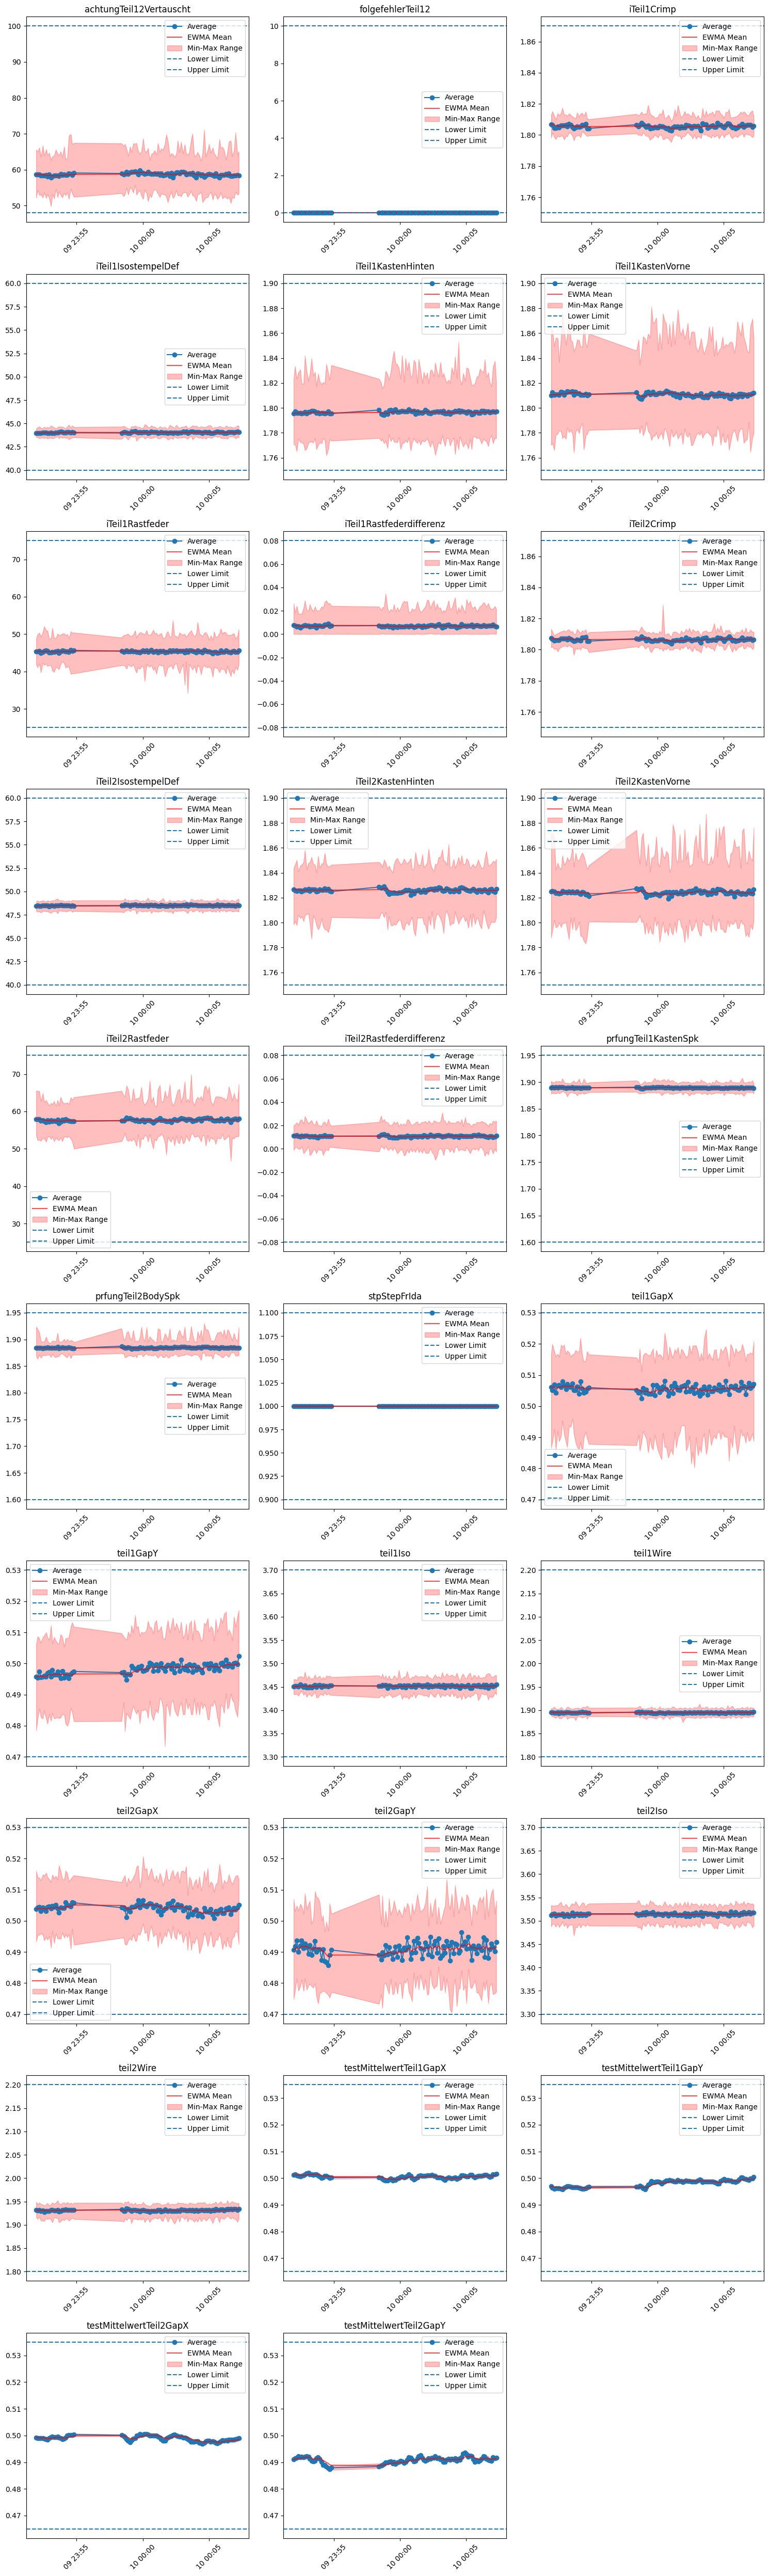

In [110]:
total_vars = sorted(small_d2.variable_name.unique().tolist())
cols = 3
rows = math.ceil(len(total_vars) / cols)

fig_width = 5 * cols  # width per column
fig_height = 5 * rows  # height per row

plt.figure(figsize=(fig_width, fig_height))

for i, var in enumerate(total_vars):
    temp = small_d2[small_d2.variable_name == var]
    temp['ewma_mean'] = temp['average'].ewm(alpha=0.2, adjust=False).mean()
    temp['ewma_std'] = temp['std'].ewm(alpha=0.2, adjust=False).mean()
    
    lowerLimit = temp.lowerLimit.values[0]
    upperLimit = temp.upperLimit.values[0]
    nominalValue = temp.nominalValue.values[0]
    
    time = temp.timestamp
    min_val = temp['min']
    max_val = temp['max']
    
    # Average value plotting
    plt.subplot(rows, cols, i+1)
    plt.plot(temp.timestamp, temp.average, marker = 'o', label='Average')
    plt.plot(temp.timestamp, temp.ewma_mean, label='EWMA Mean', color='red', alpha=0.7)
    
    # # Std Dev plotting
    # plt.plot(temp.timestamp, temp['std'], marker = 'o', label='Std Dev', color='green')
    # plt.plot(temp.timestamp, temp.ewma_std, label='EWMA Std', color='purple')
    
    # Min and max value area
    # plt.vlines(x=time, ymin=min_val,ymax=max_val,  linewidth=1)
    plt.fill_between(
        time,
        min_val,
        max_val,
        alpha=0.25,  # transparency
        color='red',
        label='Min-Max Range'
    )   

    # Upper and Lower Limits
    plt.axhline(lowerLimit + nominalValue, linestyle = "--", label="Lower Limit")
    plt.axhline(upperLimit + nominalValue, linestyle="--", label="Upper Limit")
    
    # Timestamp rotate to see it
    plt.xticks(rotation = 45)
    
    # Lables
    plt.title(f"{var}")
    plt.legend()
    # plt.ylim(nominalValue - 1.5*abs(lowerLimit), nominalValue + 1.5*abs(upperLimit))
    # others
plt.tight_layout()
plt.show()
    